<a href="https://colab.research.google.com/github/Irina-Na/TimeSeriesForecasting/blob/main/Consumption_Forecast_LSTM%2BARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 3.6 MB/s 
     |████████████████████████████████| 9.8 MB 53.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import datetime as dt
import calendar
import matplotlib
import statsmodels
import scipy as sc

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace imSARIMAX
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose



import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

%matplotlib inline
%pylab inline
plt.style.use('seaborn-whitegrid')
import os


Populating the interactive namespace from numpy and matplotlib


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UB/data/1.csv')
df=df[df.num.isin([255])]
df['Full_consumption']=df['Consumption/load_from_grid']+ df['Consumption/load_from_solar']+ df['Consumption/load_from_battery']
df.time=pd.to_datetime(df.time)
df['Date']=df.time.dt.date
df['Weekday']=df.time.dt.dayofweek
df['Hour']=df.time.dt.hour
df=df[df['Date'] > dt.date(2021,1,1)]
df.set_index('time', inplace=True, drop=True )
df.sort_index(inplace=True)
df.index.is_monotonic_increasing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



True

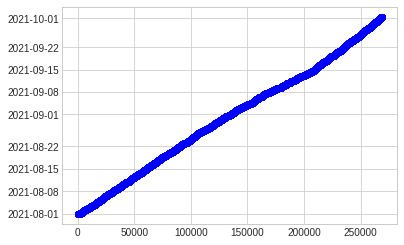

In [ ]:
df5=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UB/data/5.csv')
df5=df5[df5.num.isin([255])]
df5.time=pd.to_datetime(df5.time)
df5['Date']=df5.time.dt.date
df5['Full_consumption']=df5['Consumption/load_from_grid']+ df5['Consumption/load_from_solar']+ df5['Consumption/load_from_battery']
df5.set_index('time', inplace=True)
if not df5.index.is_monotonic_increasing:
  plt.plot(df5.index, 'bo')
  df5=df5[df5['Date'] > dt.date(2021,1,1)]
  df5.index.is_monotonic_increasing

plt.plot(df5.index, 'bo')

# Find the missing time periods

In [ ]:
def Find_missing_periods(df):
  df['Time']=list(df.index)
  periods=[]
  for i in range(1,len(df)):
    if (df.Time[i] - df.Time[i-1] )> dt.timedelta(minutes=1):
      #print(f'Found timedelta {i} {df.Time[i] - df.Time[i-1]} timestamps: {df.Time[i]} and {df.Time[i-1]}')
      periods.append(i)
  return periods

In [ ]:
x_df1=Find_missing_periods(df)

In [ ]:
x_df5=Find_missing_periods(df5)
x_df5.insert(0,0)
x_df5.append(len(df5))
index_max_diff_5 = np.argmax(np.diff(x_df5))
x_df5, index_max_diff_5, x_df5[index_max_diff_5]

([0, 16178, 160742, 219916, 268851], 1, 16178)

In [ ]:
df_5=df5[['Full_consumption']][x_df5[index_max_diff_5]:x_df5[index_max_diff_5+1]]
df_1=df[['Full_consumption']][:x_df1[0]]

In [ ]:
# Create Training and Test 30mins samples
train1 = df_1.resample('30T').mean()[:'2021-08-20']
test1 = df_1.resample('30T').mean()['2021-08-20':]

train5 = df_5.resample('30T').mean()[: round(len(df_5.resample('30T').mean())*0.5)]
test5 = df_5.resample('30T').mean()[round(len(df_5.resample('30T').mean())*0.5):]



In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'acf1':acf1})

# LSTM forecast

In [ ]:
# Create Training and Test
train1 = df_1.resample('30T').mean()[:'2021-08-20']
test1 = df_1.resample('30T').mean()['2021-08-20':]

train5 = df_5.resample('30T').mean()[: round(len(df_5.resample('30T').mean())*0.5)]
test5 = df_5.resample('30T').mean()[round(len(df_5.resample('30T').mean())*0.5):]


In [ ]:
def create_sequences(X, time_steps, n_features=1):
			# split a univariate sequence into samples
      Xs, ys = [], []
      for i in range(len(X)-time_steps):
          Xs.append(X.iloc[i:(i+time_steps)].values)
          ys.append(X.iloc[i+time_steps])
      Xs, ys = np.array(Xs), np.array(ys)
      return Xs.reshape((Xs.shape[0], Xs.shape[1], n_features)), ys.reshape(len(ys), n_features)


def LSTM_forecasting (train, test, n_steps):
			#scaling

			scaler = StandardScaler()
			scaler = scaler.fit(train)
			train[train.columns[0]] = scaler.transform(train)
			test[test.columns[0]]= scaler.transform(test)
			n_features = 1
			# split into samples and reshape
			X_train, y_train = create_sequences(train, n_steps)
			X_test, y_test = create_sequences(test, n_steps)


			# define model
			model = Sequential()
			model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
			model.add(Dense(1))
			model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])

			# fit model
			model.fit(X_train, y_train, epochs=200, verbose=0)

			# demonstrate prediction

			#X_train_pred = model.predict(X_train, verbose=0)
			X_test_pred = model.predict(X_test, verbose=0)
			

			predict = pd.DataFrame(test[n_steps:])
			predict['Forecast'] = X_test_pred
			predict['Forecast'] = scaler.inverse_transform(predict[['Forecast']])
			predict['Actual'] = scaler.inverse_transform (test[[test.columns[0]]][n_steps:])
			#print(test[:10], predict[:10])		
 		
			return predict, scaler

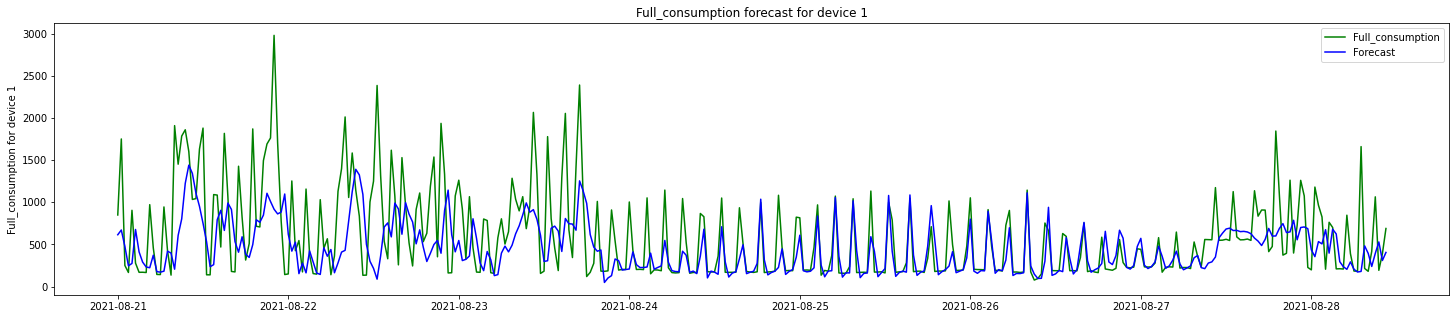

Forecasts MAPE: 58.23712158203125, MAE: 302.91754150390625


In [ ]:
#MAE+MAE
predict, scaler=LSTM_forecasting (train1, test1, 24*2)

fig, ax = plt.subplots(figsize=(25, 5))
plt.plot((predict['Actual']), 'g', label='Full_consumption')
plt.plot((predict['Forecast']), 'b', label='Forecast')

plt.ylabel('Full_consumption for device 1')
plt.title('Full_consumption forecast for device 1')
plt.legend()
plt.show()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mae = tf.keras.losses.MeanAbsoluteError()
print (f'Forecasts MAPE: {mape(predict.Actual, predict.Forecast).numpy()}, MAE: {mae(predict.Actual, predict.Forecast).numpy()}')

In [ ]:
forecast_accuracy(predict.Forecast, predict.Actual)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



{'acf1': 0.15885857203717219,
 'corr': 0.4847539607606482,
 'mae': 302.9175679989469,
 'mape': 0.5823712641980741,
 'me': -147.94531861227628,
 'minmax': 0.3539904057922547,
 'mpe': 0.14953005795044513,
 'rmse': 475.8387716400936}

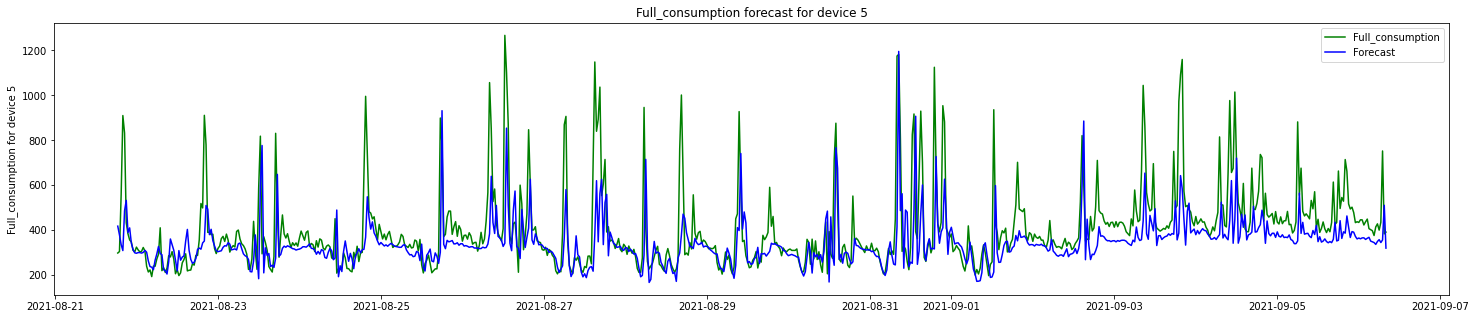

Forecasts MAPE: 18.328371047973633, MAE: 89.89437103271484


In [ ]:
#MAE+MAE
predict5, scaler5=LSTM_forecasting (train5, test5, 24*2)

fig, ax = plt.subplots(figsize=(25, 5))

plt.plot((predict5['Actual']), 'g', label='Full_consumption')
plt.plot((predict5['Forecast']), 'b', label='Forecast')

plt.ylabel('Full_consumption for device 5')
plt.title('Full_consumption forecast for device 5')
plt.legend()
plt.show()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mae = tf.keras.losses.MeanAbsoluteError()
print (f'Forecasts MAPE: {mape(predict5.Actual, predict5.Forecast).numpy()}, MAE: {mae(predict5.Actual, predict5.Forecast).numpy()}')

In [ ]:
forecast_accuracy(predict5.Forecast, predict5.Actual)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



{'acf1': 0.2048164513418056,
 'corr': 0.5516533200755088,
 'mae': 89.89437205920314,
 'mape': 0.18328367028432235,
 'me': -60.1624154664875,
 'minmax': 0.1694380582962376,
 'mpe': -0.08278085010066766,
 'rmse': 158.7159342144323}

Conclusion: Moreover, the neural-network architecture here is a toy model. It can be easily improved by adding CNN and dropout layers. The CNN is useful here since there are correlations in data (CNN layer is a good way to probe the local structure of data).

# ARIMA Analysis

In [ ]:
print(list(zip( ['JB', 'p-value', 'skew', 'kurtosis'], sm.stats.stattools.jarque_bera(df.Full_consumption))))
print(list(zip( ['JB', 'p-value', 'skew', 'kurtosis'], sm.stats.stattools.jarque_bera(df5.Full_consumption))))

[('JB', 395764787.9279912), ('p-value', 0.0), ('skew', 4.476628602753203), ('kurtosis', 192.96967818385468)]
[('JB', 3599569.0372533402), ('p-value', 0.0), ('skew', 3.390456038668147), ('kurtosis', 19.59362400284138)]


Time series 1 and 5 have normal distribution

## Stationarity test
And will check Stationarity (Augmented Dickey-Fuller unit root test). If p-value< 0.05, the series is stationary

In [ ]:
data=df_1
print(f'Stationarity (Augmented Dickey-Fuller unit root test) Day p-value: { sm.tsa.stattools.adfuller( data)[1]}' )
data=df_5
print(f'Stationarity (Augmented Dickey-Fuller unit root test) Day p-value: { sm.tsa.stattools.adfuller( data)[1]}' )
 

Stationarity (Augmented Dickey-Fuller unit root test) Day p-value: 0.0
Stationarity (Augmented Dickey-Fuller unit root test) Day p-value: 2.0845361109022246e-30


Based on the test, time series 1 and 5 are stationary, that is, they have no seasonality and trends.
Check on sesonal decompose graphs:

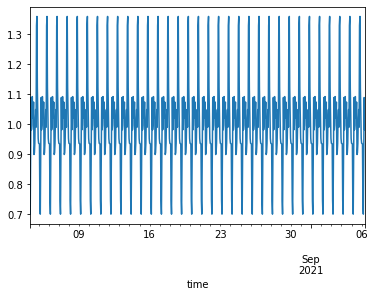

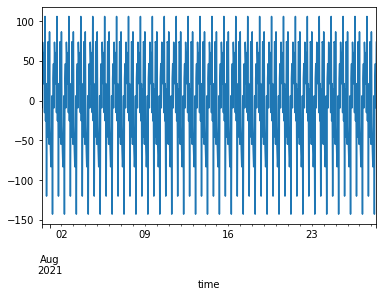

In [ ]:

result5 = seasonal_decompose(df_5.resample('H').mean(), model='multiplicative')
result5.seasonal.plot()
plt.show()
result = seasonal_decompose(df_1.resample('H').mean(), model='additive')
result.seasonal.plot()
plt.show()


More Stationarity tests:

In [ ]:
from pmdarima.arima import ADFTest, KPSSTest, PPTest

adf_test = ADFTest()
kpss_test=KPSSTest()
pp_test= PPTest()

adf_test.should_diff(df_1), adf_test.should_diff(df_5), kpss_test.should_diff(df_1), kpss_test.should_diff(df_5), pp_test.should_diff(df_1), pp_test.should_diff(df_5)

((0.01, False),
 (0.01, False),
 (0.01, True),
 (0.01, True),
 (0.01, False),
 (0.01, False))

Time series 1 and 5 belong to the TS class (stationary or stationary relative to the trend)

In [ ]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(df_1, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(df_1, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(df_1, test='pp')  # -> 0
n_adf, n_kpss,  n_pp 

(0, 1, 0)

Need 1 differencing

## Manualy p & q

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



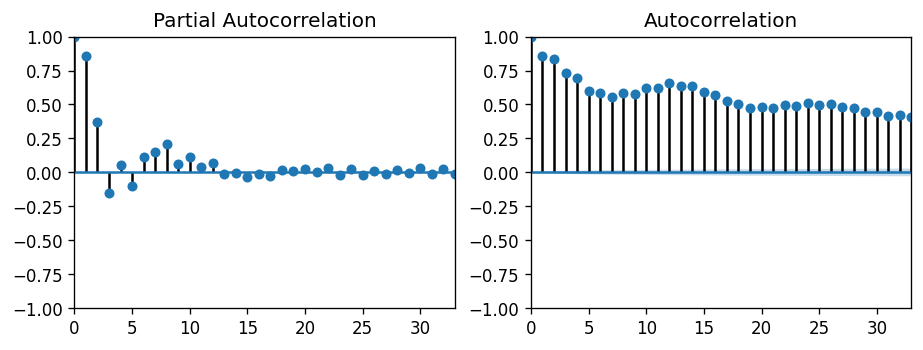

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].set(xlim=(0,33))
plot_pacf(df_1,  ax=axes[0])
axes[1].set(xlim=(0,33))
plot_acf(df_1, ax=axes[1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



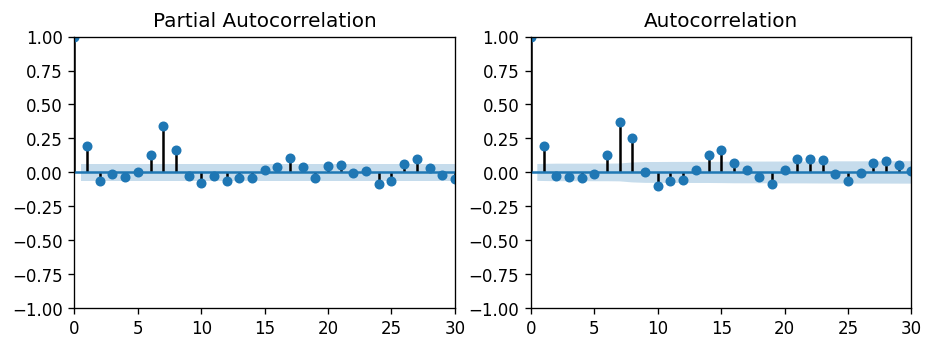

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].set(xlim=(0,30))
plot_pacf(train1 ,  ax=axes[0])
axes[1].set(xlim=(0,30))
plot_acf(train1, ax=axes[1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



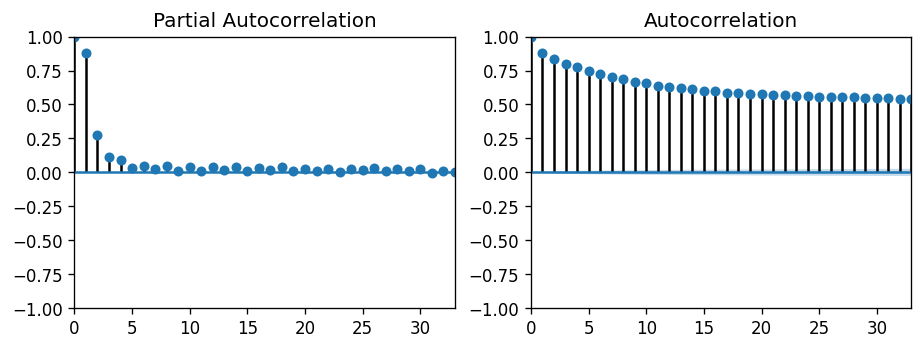

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].set(xlim=(0,33))
plot_pacf(df_5,  ax=axes[0])
axes[1].set(xlim=(0,33))
plot_acf(df_5, ax=axes[1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



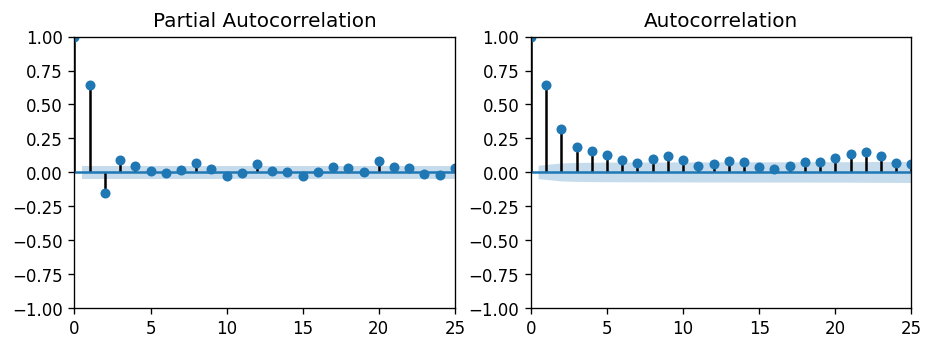

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].set(xlim=(0,25))
plot_pacf(train5,  ax=axes[0])
axes[1].set(xlim=(0,25))
plot_acf(train5, ax=axes[1])

plt.show()

for device 1:  p=1 q=1
for device 5:  p=1 q=1

## Manualy ARIMA modeling & forecasting

In [ ]:
# Create Training and Test
train1 = df_1.resample('30T').mean()[:'2021-08-20']
test1 = df_1.resample('30T').mean()['2021-08-20':]

train5 = df_5.resample('30T').mean()[: round(len(df_5.resample('30T').mean())*0.5)]
test5 = df_5.resample('30T').mean()[round(len(df_5.resample('30T').mean())*0.5):]


In [ ]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:14635.412121090574
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:14132.811668304286
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:14023.609107302138
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:13709.013141460968
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:13905.582974508068
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:13803.728022214276
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:13869.5902328296
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:13632.933592024618
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:14345.642767763118
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:14025.793176941777
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:14009.914375809538
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:13684.441343661087
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:13900.611521694602
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:13779.310116266111
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:13871.196512187144
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:13616.740968978718
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:14422.202149693963
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:14277.41215067189
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - 

##Choose best ARIMA for test1
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:13632.933592024618
ARIMA(0, 1, 1)x(1, 1, 1, 7)7 - AIC:13606.141308858994

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.0477      0.052     -0.923      0.356      -0.149       0.054
ma.S.L7       -0.7738      0.033    -23.233      0.000      -0.839      -0.709
sigma2      2.613e+05   1.59e+04     16.451      0.000     2.3e+05    2.92e+05


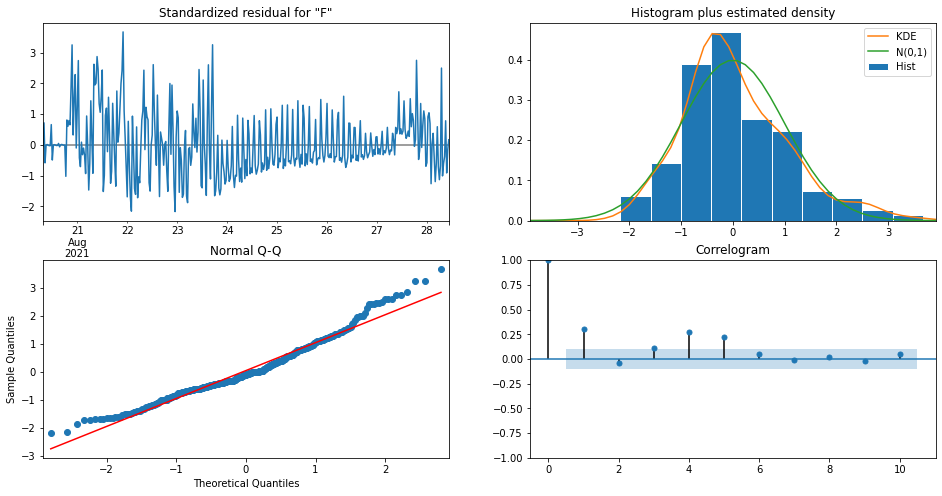

In [ ]:
mod = sm.tsa.statespace.SARIMAX(test1,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


results.plot_diagnostics(figsize=(16, 8))
plt.show()


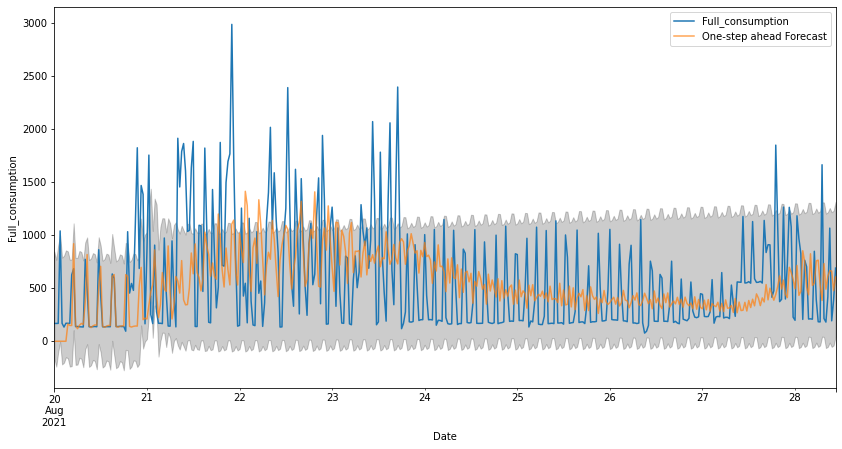

In [ ]:
pred = results.get_prediction(start=test1.index[0], end= test1.index[-1], dynamic=False )
pred_ci = pred.conf_int()

ax = test1.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Full_consumption')
plt.legend()

plt.show()



In [ ]:
forecast_accuracy(pred.predicted_mean, test1.Full_consumption)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



{'acf1': 0.298070364703799,
 'corr': 0.2738453321464219,
 'mae': 385.89647806131325,
 'mape': 1.142882502447349,
 'me': -27.385898185519384,
 'minmax': 0.4778328440794143,
 'mpe': 0.7534342755390908,
 'rmse': 506.17684092480204}

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0183      0.006   -163.167      0.000      -1.031      -1.006
ar.S.L7        0.3562      0.025     14.286      0.000       0.307       0.405
ma.S.L7       -1.0000      0.029    -33.995      0.000      -1.058      -0.942
sigma2      6.299e+04   4.67e-07   1.35e+11      0.000     6.3e+04     6.3e+04


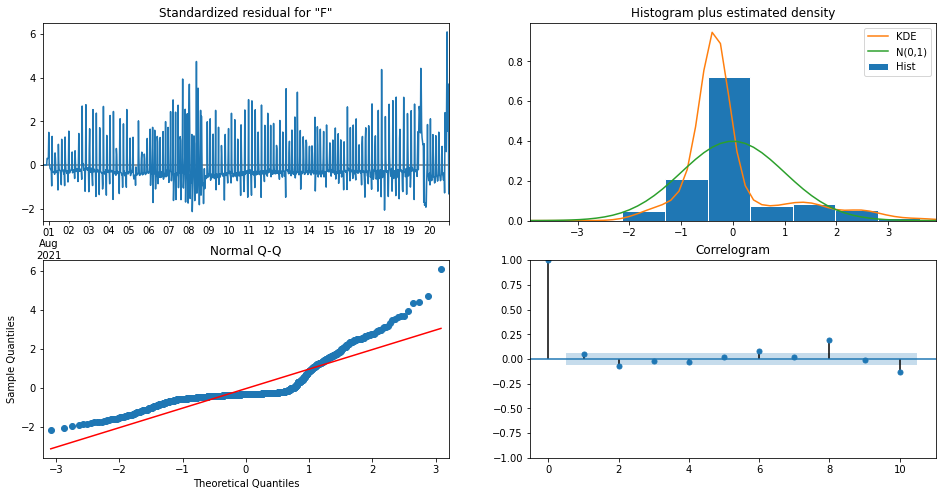

In [ ]:
mod2 = sm.tsa.statespace.SARIMAX(train1,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary().tables[1])


results2.plot_diagnostics(figsize=(16, 8))
plt.show()

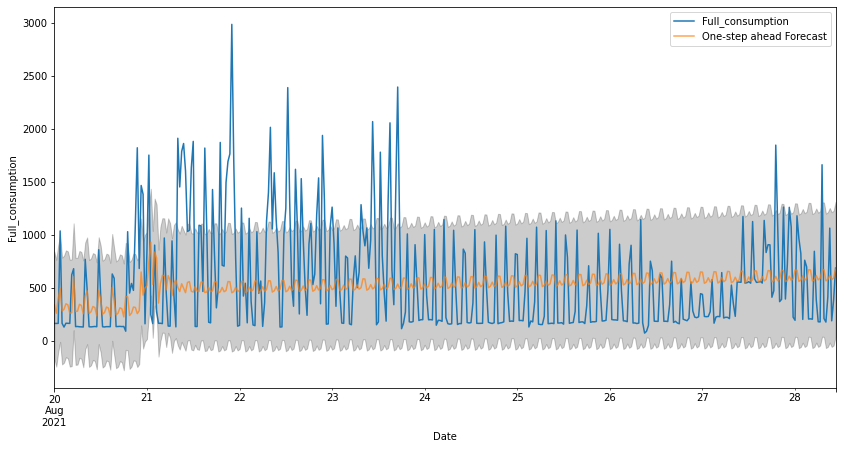

In [ ]:
pred2 = results2.get_prediction(start=test1.index[0], end= test1.index[-1], dynamic=False )
pred_ci2 = pred2.conf_int()

ax = test1.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Full_consumption')
plt.legend()

plt.show()


In [ ]:
forecast_accuracy(pred2.predicted_mean, test1.Full_consumption)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



{'acf1': 0.39956228175723324,
 'corr': 0.03911163667606167,
 'mae': 400.9252629145608,
 'mape': 1.154452008375106,
 'me': -44.16419855047309,
 'minmax': 0.5099938541645059,
 'mpe': 0.7989216279981407,
 'rmse': 514.9985154234283}

## Choose best ARIMA for test5

In [ ]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train5,
                                            order=param,
                                            seasonal_order=param_seasonal
                                        )
            

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:11622.614237019478
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:11186.201735913804
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:10650.10231134951
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:10119.69031578693
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:10685.141939087629
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:10222.446619867438
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:10451.418995526023
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:10121.18313605267
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:10893.302137966417
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:10654.953358475994
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:10355.379937098352
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:9824.676822879534
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:10349.377092588504
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:9921.441826896971
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:10136.443095366678
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:9826.135027229728
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:10017.141639743862
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:10019.105622435958
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 1, 7)7 - AIC:9887.390940027595
ARIMA(1, 0, 0)x(1, 1, 0, 7)7 - AIC:10093.727936347921
ARIMA(1, 0, 0)x(1, 1, 1, 7)7 - AIC:9798.87112192588
ARIMA(1, 0, 1)x(0, 0, 0, 7)7 - AIC:10004.69872818893
ARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:10006.49549282577
ARIMA(1, 0, 1)x(0, 1, 0, 7)7 - AIC:10293.651496437109
ARIMA(1, 0, 1)x(0, 1, 1, 7)7 - AIC:9775.637690021522
ARIMA(1, 0, 1)x(1, 0, 0, 7)7 - AIC:10006.485477011778


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:9867.591689429339
ARIMA(1, 0, 1)x(1, 1, 0, 7)7 - AIC:10073.493702334166
ARIMA(1, 0, 1)x(1, 1, 1, 7)7 - AIC:9777.568492740522
ARIMA(1, 1, 0)x(0, 0, 0, 7)7 - AIC:10014.645867501935
ARIMA(1, 1, 0)x(0, 0, 1, 7)7 - AIC:10016.597835560668
ARIMA(1, 1, 0)x(0, 1, 0, 7)7 - AIC:10477.438693229702
ARIMA(1, 1, 0)x(0, 1, 1, 7)7 - AIC:9965.02233916034
ARIMA(1, 1, 0)x(1, 0, 0, 7)7 - AIC:10016.597516827776
ARIMA(1, 1, 0)x(1, 0, 1, 7)7 - AIC:10018.597209607082
ARIMA(1, 1, 0)x(1, 1, 0, 7)7 - AIC:10249.744806242581
ARIMA(1, 1, 0)x(1, 1, 1, 7)7 - AIC:9967.01414701761
ARIMA(1, 1, 1)x(0, 0, 0, 7)7 - AIC:9840.001815837466
ARIMA(1, 1, 1)x(0, 0, 1, 7)7 - AIC:9841.88150974649


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(1, 1, 1)x(0, 1, 0, 7)7 - AIC:10308.799839328378


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(1, 1, 1)x(0, 1, 1, 7)7 - AIC:9798.82203175343
ARIMA(1, 1, 1)x(1, 0, 0, 7)7 - AIC:9841.888524951128
ARIMA(1, 1, 1)x(1, 0, 1, 7)7 - AIC:9842.734549945551


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(1, 1, 1)x(1, 1, 0, 7)7 - AIC:10089.621122820809


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(1, 1, 1)x(1, 1, 1, 7)7 - AIC:9800.7754001929


Choose the best:

ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:9824.676822879534

ARIMA(1, 0, 0)x(0, 1, 1, 7)7 - AIC:9796.923200477908


ARIMA(1, 0, 1)x(0, 1, 1, 7)7 - AIC:9775.637690021522



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5490      0.021     26.292      0.000       0.508       0.590
ma.S.L7       -1.0000     33.160     -0.030      0.976     -65.993      63.993
sigma2      1.419e+04   4.71e+05      0.030      0.976   -9.08e+05    9.36e+05


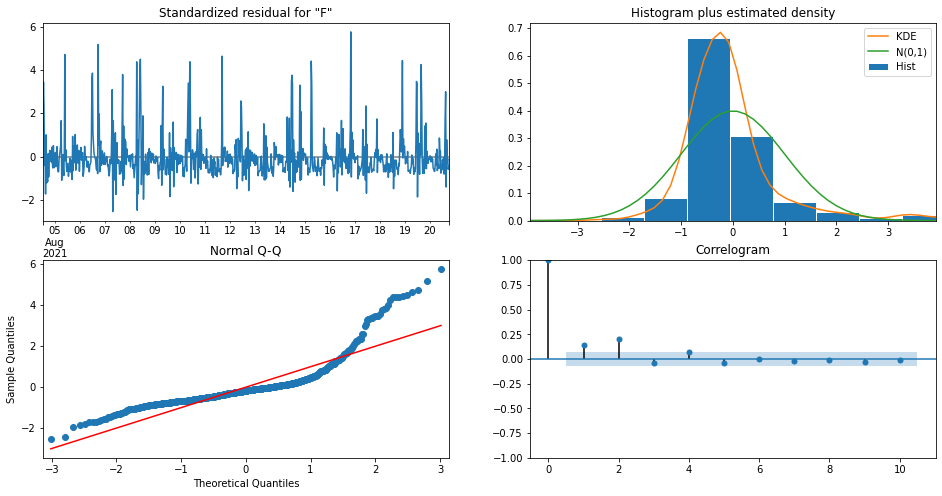

In [ ]:
mod5_1 = sm.tsa.statespace.SARIMAX(train5,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results5_1 = mod5_1.fit()
print(results5_1.summary().tables[1])


results5_1.plot_diagnostics(figsize=(16, 8))
plt.show()

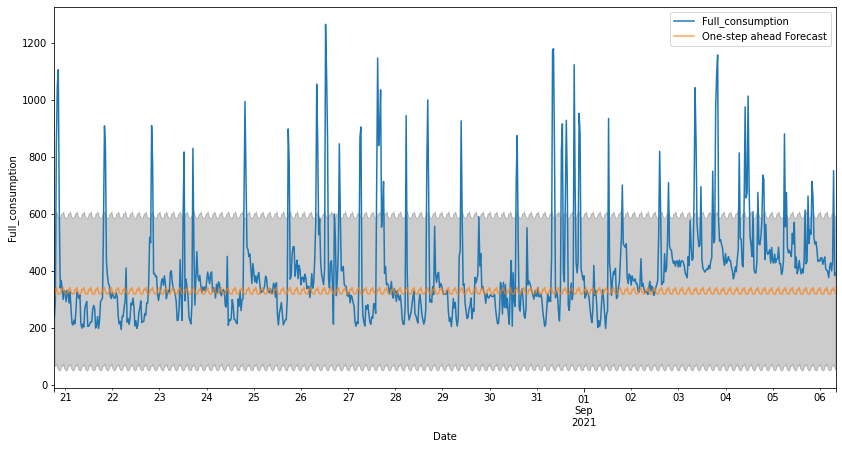

In [ ]:
pred5_1 = results5_1.get_prediction(start=test5.index[0], end= test5.index[-1], dynamic=False )
pred_ci = pred5_1.conf_int()

ax = test5.plot(label='observed')
pred5_1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Full_consumption')
plt.legend()

plt.show()


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5768      0.016     36.323      0.000       0.546       0.608
ma.S.L7       -0.9992      0.233     -4.291      0.000      -1.456      -0.543
sigma2      1.372e+04   3137.287      4.375      0.000    7575.628    1.99e+04


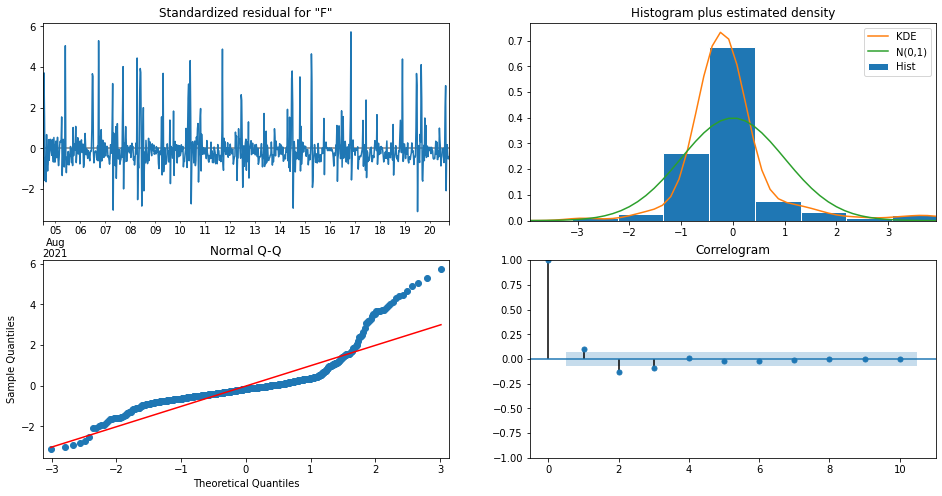

In [ ]:
mod5_2 = sm.tsa.statespace.SARIMAX(train5,
                                order=(1, 0, 0),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results5_2 = mod5_2.fit()
print(results5_2.summary().tables[1])


results5_2.plot_diagnostics(figsize=(16, 8))
plt.show()

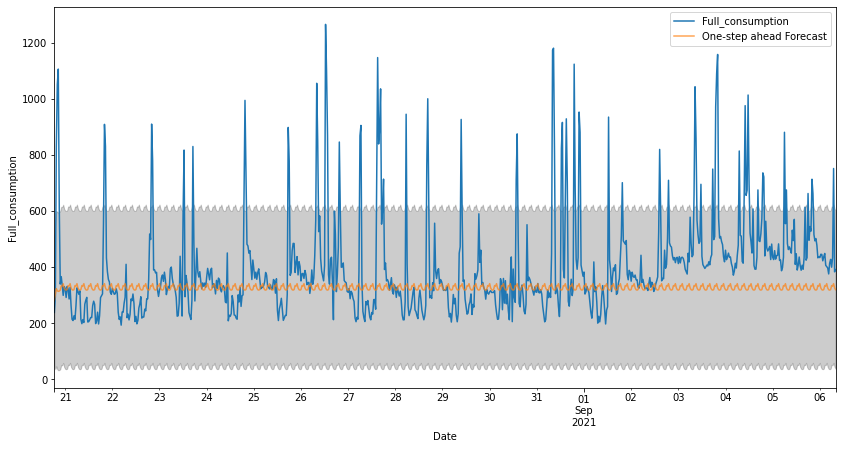

In [ ]:
pred5_2 = results5_2.get_prediction(start=test5.index[0], end= test5.index[-1], dynamic=False )
pred_ci = pred5_2.conf_int()

ax = test5.plot(label='observed')
pred5_2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Full_consumption')
plt.legend()

plt.show()


Device 5 has no weekly seasonality 